# Punto 3

## Librerías utilizadas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from tqdm.notebook import tqdm
import warnings
import time 

warnings.filterwarnings("ignore")


Luego de realizar el EDA de estos conjuntos de datos se decidió ajustar los modelos predictivos con las siguientes variables:

- Variables explicativas: TransactionDT, TransactionAmt, C3, C5, card4, card6, isFraud, card3, card2
- Variable respuesta: isFraud

Como ya tenemos establecido cuál será el conjunto de datos que utilizaremos para entrenar los modelos de clasificación, procedemos a construir el Pipeline. Además, escogió una validación cruzada estratificada ya que nos interesa que en cada partición quede la misma proporción de etiquetas.

In [5]:
data = pd.read_csv('dataset_final (1).csv')

## Sin Balanceo

In [6]:
X = data.drop(columns=['isFraud'])
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


  0%|          | 0/6 [00:00<?, ?it/s]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


 17%|█▋        | 1/6 [14:06<1:10:31, 846.29s/it]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


 33%|███▎      | 2/6 [27:18<54:17, 814.33s/it]  

Fitting 5 folds for each of 5 candidates, totalling 25 fits


 50%|█████     | 3/6 [27:47<22:47, 455.90s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


 67%|██████▋   | 4/6 [29:26<10:29, 314.83s/it]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


 83%|████████▎ | 5/6 [29:35<03:24, 204.80s/it]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


100%|██████████| 6/6 [58:17<00:00, 582.93s/it]


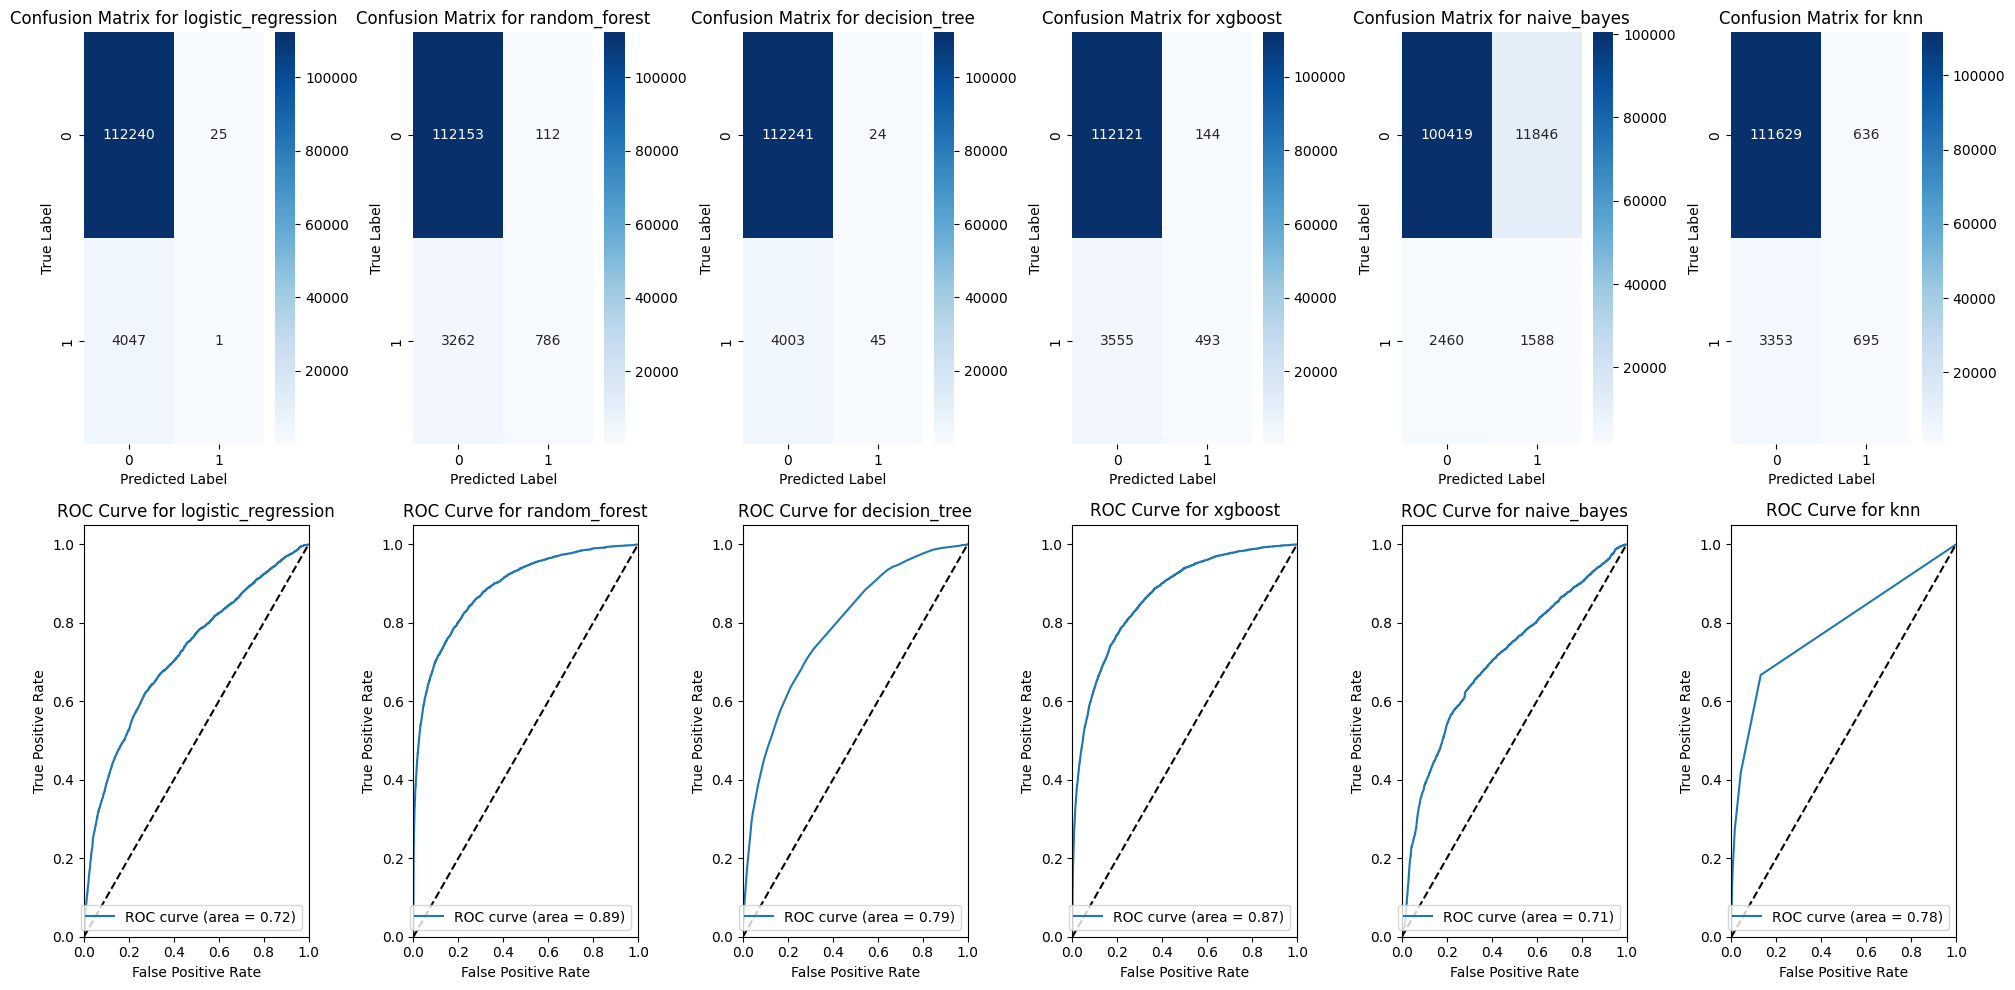

,Model,Precision,Recall,F1-score,AUC,Best Parameters,Elapsed Time
0,logistic_regression,0.038462,0.000247,0.000491,0.719853,"{'logistic_regression__C': 1, 'logistic_regres...",845.374779
1,random_forest,0.875278,0.194170,0.317833,0.888894,"{'random_forest__max_depth': 20, 'random_fores...",789.314056
2,decision_tree,0.652174,0.011117,0.021861,0.786860,{'decision_tree__max_depth': 7},28.749411
3,xgboost,0.773940,0.121789,0.210459,0.869414,"{'xgboost__max_depth': 7, 'xgboost__n_estimato...",97.446001
4,naive_bayes,0.118208,0.392292,0.181673,0.706789,{'naive_bayes__var_smoothing': 1e-06},9.009001
5,knn,0.522164,0.171690,0.258412,0.784977,{'knn__n_neighbors': 7},1392.675007


In [8]:
pipelines = {
    'logistic_regression': Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression(max_iter=10000, solver='liblinear', penalty='l2'))
    ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('random_forest', RandomForestClassifier(random_state=2))
    ]),
    'decision_tree': Pipeline([
        ('scaler', StandardScaler()),
        ('decision_tree', DecisionTreeClassifier(random_state=0))
    ]),
    'xgboost': Pipeline([
        ('scaler', StandardScaler()),
        ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ]),
    'naive_bayes': Pipeline([
        ('scaler', StandardScaler()),
        ('naive_bayes', GaussianNB())
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])
}

param_grid = {
    'logistic_regression': {
        'logistic_regression__C': [0.1, 1, 10, 100],
        'logistic_regression__penalty': ['l1', 'l2']
    },
    'random_forest': {
        'random_forest__n_estimators': [5, 10, 50],
        'random_forest__max_depth': [None, 10, 20, 30]
    },
    'decision_tree': {
        'decision_tree__max_depth': [3, 4, 5, 6, 7]
    },
    'xgboost': {
        'xgboost__n_estimators': [50, 100, 200],
        'xgboost__max_depth': [3, 5, 7]
    },
    'naive_bayes': {
        'naive_bayes__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    },
    'knn': {
        'knn__n_neighbors': [3, 5, 7],
    }
}

results = []

fig, axes = plt.subplots(2, 6, figsize=(20, 10)) 

for i, model in enumerate(tqdm(pipelines)):
    start_time = time.time()  
    grid_search = GridSearchCV(pipelines[model], param_grid[model], cv=StratifiedKFold(n_splits=5), scoring='roc_auc', verbose=1)
    grid_search.fit(X_train, y_train)
    end_time = time.time() 

    y_pred = grid_search.best_estimator_.predict(X_test)
    y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  
    
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': model,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc,
        'Best Parameters': grid_search.best_params_,
        'Elapsed Time': end_time - start_time
    })

    ax1 = axes[i // 6, i % 6]  
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax1)
    ax1.set_title(f"Confusion Matrix for {model}")
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    ax2 = axes[(i // 6) + 1, i % 6] 
    ax2.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve for {model}')
    ax2.legend(loc="lower right")

plt.tight_layout() 
plt.show()

error_table = pd.DataFrame(results)
error_table


*Regresión Logística:*

- **Matriz de confusión:** Tiene un alto número de verdaderos negativos (112,240) y un número relativamente bajo de verdaderos positivos (4,047). Esto sugiere que el modelo es muy bueno para predecir la clase negativa (0), pero no tan bueno para la clase positiva (1). Solo tiene 25 falsos positivos, lo cual es excelente, pero con solo 1 falso negativo.
- **Curva ROC:** La curva muestra un AUC de 0.72, lo que es moderado. La curva ROC está por encima de la línea de no-discriminación (línea punteada), lo que indica que el modelo tiene una capacidad aceptable para distinguir entre las clases.

*Random Forest:*

- **Matriz de confusión:** Muestra un alto número de verdaderos negativos (112,153) y un número decente de verdaderos positivos (3,262), con más falsos positivos (112) y falsos negativos (786) que la regresión logística. Esto indica un rendimiento no tan bueno para predecir la clase positiva en comparación con la clase negativa.
- **Curva ROC:** Tiene un AUC alto de 0.89, lo cual es excelente. La curva se desvía significativamente hacia la esquina superior izquierda, lo que indica un buen rendimiento en términos de sensibilidad y especificidad.

*Árbol de Decisión:*

- **Matriz de confusión:** Con 112,241 verdaderos negativos y 4,003 verdaderos positivos, su rendimiento es comparable al de la regresión logística en la clasificación de negativos, pero tiene más falsos positivos (24) y un número significativamente más alto de falsos negativos (45).
- **Curva ROC:** El AUC es 0.79, lo que indica un rendimiento bueno, mejor que un clasificador aleatorio, pero no tan bueno como el bosque aleatorio.

*XGBoost:*

- **Matriz de confusión:** Tiene muchos verdaderos negativos (112,121) y verdaderos positivos (3,555), con falsos positivos (144) y falsos negativos (493) más elevados que la regresión logística pero menos que el bosque aleatorio.
- **Curva ROC:** Con un AUC de 0.87, muestra un excelente rendimiento, casi comparable al del bosque aleatorio, con una buena discriminación entre las clases.

*Naive Bayes:*

- **Matriz de confusión:** Presenta un número menor de verdaderos negativos (100,419) en comparación con otros modelos y verdaderos positivos (2,460), con un alto número de falsos positivos (11,846), lo que indica una tendencia a predecir incorrectamente la clase positiva cuando en realidad es negativa.
- **Curva ROC:** El AUC es 0.71, lo que es el segundo más bajo y sugiere una capacidad limitada para distinguir entre las clases.

*KNN:*

- **Matriz de confusión:** Muestra un buen número de verdaderos negativos (111,629), pero no tantos verdaderos positivos (3,353) como otros modelos. También tiene un número moderado de falsos positivos (636) y falsos negativos (695), lo que indica un equilibrio más moderado en la clasificación de ambas clases.
- **Curva ROC:** El AUC es 0.78, lo que indica un buen rendimiento, aunque no es tan alto como el del bosque aleatorio o XGBoost, pero sigue siendo mejor que un clasificador aleatorio.

En resumen, mientras que el modelo de Random Forest y XGBoost muestran un rendimiento sobresaliente tanto en la matriz de confusión como en la curva ROC, Naive Bayes parece tener problemas, particularmente con la alta tasa de falsos positivos. El modelo KNN, aunque no es el peor, muestra un compromiso en la capacidad de clasificar correctamente las instancias positivas, y la regresión logística muestra una capacidad moderada general con cierta debilidad en la clasificación de las instancias positivas.